In [1]:
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf

In [3]:
import threading
import os
import cPickle as pickle
import logging
import pprint
import glob
import collections
import struct
import json
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)


In [4]:
logging.info('abc')

08/15/2017 04:04:39 AM INFO: abc


In [5]:
class GeneratorRunner(object):
    "Custom runner that that runs an generator in a thread and enqueues the outputs."

    def __init__(self, generator, placeholders, enqueue_op, close_op):
        self._generator = generator
        self._placeholders = placeholders
        self._enqueue_op = enqueue_op
        self._close_op = close_op

    def _run(self, sess, coord):
        try:
            while not coord.should_stop():
                try:
                    values = next(self._generator)

                    assert len(values) == len(self._placeholders), \
                        'generator values and placeholders must have the same length'

                    feed_dict = {placeholder: value \
                        for placeholder, value in zip(self._placeholders, values)}
                    sess.run(self._enqueue_op, feed_dict=feed_dict)
                except (StopIteration, tf.errors.OutOfRangeError, tf.errors.DeadlineExceededError, tf.errors.CancelledError) as e:
                    logging.warning ("%s %s %s", self.__class__.__name__, "exception:", str(type(e)))
                    try:
                        sess.run(self._close_op)
                    except Exception:
                        pass
                    return
        except Exception as ex:
            if coord:
                logging.info ("%s %s %s %s", self.__class__.__name__, "request stop from", self._run.__name__, str(ex))
                coord.request_stop(ex)
                pass
            else: 
                raise

    def create_threads(self, sess, coord=None, daemon=False, start=False):
        "Called by `start_queue_runners`."

        thread = threading.Thread(
            target=self._run,
            args=(sess, coord))

        if coord:
            coord.register_thread(thread)

        if daemon:
            thread.daemon = True

        if start:
            thread.start()

        return [thread]

def read_batch_generator(
        generator, dtypes, shapes, batch_size,
        queue_capacity=10000,
        allow_smaller_final_batch=False):
    "Reads values from an generator, queues, and batches."

    assert len(dtypes) == len(shapes), 'dtypes and shapes must have the same length'
    logging.info('shapes: %s, types: %s, batchsize: %d', str(shapes), str(dtypes), batch_size)
    queue = tf.FIFOQueue(
        capacity=queue_capacity,
        dtypes=dtypes,
        shapes=shapes)

    placeholders = [tf.placeholder(dtype, shape) for dtype, shape in zip(dtypes, shapes)]

    enqueue_op = queue.enqueue(placeholders)
    close_op = queue.close(cancel_pending_enqueues=True)
    global_close_ops.append(close_op)
    queue_runner = GeneratorRunner(generator, placeholders, enqueue_op, close_op)
    tf.train.add_queue_runner(queue_runner)

    if allow_smaller_final_batch:
        return queue.dequeue_up_to(batch_size)
    else:
        return queue.dequeue_many(batch_size)    

In [6]:
LEN1=64*2
import Queue
class MemoryGenerator(object):
    def __init__(self, daily_data,attrib_data, epochs=np.inf):
        self.daily_data = daily_data
        self.attrib_data = attrib_data        
        self.shuffle=True
        self.epochs = epochs
        self.N = len(self.daily_data)*10
        self.curr_epoch = 1
        self.curr_i = 0
        self.q = Queue.Queue()
        if self.shuffle:
            self.do_shuffle()
    def __iter__(self):
        return self
    def do_shuffle(self):
        idx = np.random.permutation(range(len(self.daily_data)))
        self.daily_data = self.daily_data[idx]     
        self.attrib_data = self.attrib_data[idx]
    def fill_queue(self):
        for _ in range(100):
            i=int(np.random.random()*len(self.daily_data))
            attrib_row=self.attrib_data[i]
            row=self.daily_data[i]
            len1=LEN1
            len2=60
            j=int(np.random.random()*(len(row)-1))
            part_x=row[:j]
            if len(part_x)>=len1:
                x=part_x[len(part_x)-len1:]
            else:
                x=np.zeros(len1,dtype=np.float32)
                x[len1-len(part_x):]=part_x
            part_y=row[j:j+len2]
            y=np.zeros(len2,dtype=np.float32)
            y[:len(part_y)]=part_y
            mask=np.zeros(len2,dtype=np.float32)
            mask[:len(part_y)]=1
            self.q.put((x.astype(np.float32),attrib_row.astype(np.float32),np.array(y,dtype=np.float32),mask))
    def __next__(self):
        return self.next()
    def next(self):
        if self.curr_i >= self.N:
            self.curr_i = 0
            self.curr_epoch += 1
            if self.curr_epoch > self.epochs: raise StopIteration
            if self.shuffle: 
                self.do_shuffle()
        if self.q.empty(): self.fill_queue()
        X1,X2, y,mask = self.q.get()
        self.curr_i += 1
        return X1,X2, y,mask 


In [7]:
def make_train_readers(daily_data,attrib_data, nrows=None, batchsize=60):
    print daily_data.shape, attrib_data.shape
    train_generator = MemoryGenerator(daily_data,attrib_data)
    return read_batch_generator(train_generator, [tf.float32, tf.float32, tf.float32, tf.float32], 
                                [(LEN1,), (12,), (60,),(60,)], batchsize, allow_smaller_final_batch=True),train_generator

In [8]:
locales=sorted([u'en', u'ja', u'de', u'fr', u'zh', u'ru', u'es'])
locale_map={v:u for u,v in enumerate(locales)}
locale_map

{u'de': 0, u'en': 1, u'es': 2, u'fr': 3, u'ja': 4, u'ru': 5, u'zh': 6}

In [9]:
access_map={u'all-access':0, u'mobile-web':1, u'desktop':2}
agent_map={u'all-agents':0, u'spider':1}
access_map,agent_map

({u'all-access': 0, u'desktop': 2, u'mobile-web': 1},
 {u'all-agents': 0, u'spider': 1})

In [10]:
def f_map(series, data_map):
    lst=[]
    keys=list(data_map.keys())
    for k in keys:
        lst.append(series.map(lambda u: (u==k)*1))
    df=pd.concat(lst,axis=1)
    df.columns=[series.name+"_"+u for u in keys]
    return df

In [11]:
def make_data():
    import pandas as pd
    csv_path="../input/newtrain_1.csv"
    data = pd.read_csv(csv_path, nrows=None)
    datecols=[u for u in data.columns if u.startswith("20")]
    daily_data=data[datecols].values.astype(np.float32)
    attrib_data=pd.concat([f_map(data.locale,locale_map),
                           f_map(data.agent,agent_map),
                           f_map(data.access,access_map)],axis=1).values.astype(np.float32)    
    print daily_data.shape,attrib_data.shape
    return daily_data,attrib_data

In [12]:
daily_data,attrib_data=make_data()

(145063, 550) (145063, 12)


In [13]:
print np.mean(daily_data==0)
daily_data += (daily_data==0)*0.1
print np.mean(daily_data==0)

0.0909115851232
0.0


In [14]:
if 0:
    global_close_ops = []
    #daily_data,attrib_data=make_data()
    _, generator=make_train_readers(daily_data,attrib_data)
    a,b,c,d= generator.next()
    print a,b,c,d    
    print a.shape,b.shape,c.shape,d.shape


In [15]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>" % size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    from IPython.display import clear_output, Image, display, HTML

    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


In [16]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def dense(x, size, scope, with_activation=True):
    if 1:
        with tf.variable_scope(scope):
            w = weight_variable(shape=[int(x.get_shape()[-1]), size], name=None)
            b = bias_variable(shape=[size], name=None)
            h1 = tf.matmul(x, w) + b
            layer=tf.sigmoid(h1) if with_activation else h1
            print layer.get_shape()
    return layer,w,b
from tensorflow.contrib import rnn
def lstm(x,x2, n_hiddens, n_input, n_output, scope):
    if 1:
        with tf.variable_scope(scope):
            x = tf.reshape(x, [-1, n_input])
            x = tf.split(x,n_input,1)
            basic_rnn_cells = [rnn.BasicLSTMCell(n_hidden) for n_hidden in n_hiddens]
            rnn_cell = rnn.MultiRNNCell(basic_rnn_cells)
            outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32) 
            concat_x=tf.concat([outputs[-1],x2],-1)
            print outputs[-1].get_shape(), concat_x.get_shape()             
            return concat_x

def get_Xy(x_size,x2_size,y_size):
    X = tf.placeholder("float", shape=[None, x_size], name='input_x')
    X2 = tf.placeholder("float", shape=[None, x2_size], name='input_x2')    
    l2_scale = tf.placeholder(tf.float32, name='l2_scale')
    y = tf.placeholder("float", shape=[None, y_size], name='input_y')
    mask = tf.placeholder("float", shape=[None, y_size], name='mask')
    return X,X2, y,mask, l2_scale

In [45]:
class MyModel(object):
    def __init__(self, x_size,y_size, n_hiddens,l2_scale,phase=True ):
        self.phase=phase
        n_hiddens=n_hiddens
        self.graph = tf.Graph()
        self.all_denses = []
        with self.graph.as_default(): 
            self.X, self.X2, self.y, self.mask, self.l2_scale = get_Xy(x_size,12, y_size)
            assert(x_size == self.X.get_shape()[1])
            with tf.variable_scope("nodes"):
                self.X, self.y, self.loss, self.smape \
                     = self.make_model(x_size=x_size, y_size=y_size, n_hiddens=n_hiddens)

            
            with tf.variable_scope('saver'):
                    self.saver = tf.train.Saver()

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.variable_scope('optimizer'):
                with tf.control_dependencies(update_ops):
                    self.optimizer = tf.train.AdamOptimizer()#.minimize(self.loss)
                    gvs = self.optimizer.compute_gradients(self.loss)
                    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
                    self.train_op = self.optimizer.apply_gradients(capped_gvs)
        self._session = None    
    @property
    def session(self): 
        if self._session is None:
            self._session = tf.Session(graph=self.graph)
        return self._session
    
    def close_session(self):
        if self._session is not None:
            self._session.close()
            self._session = None
    def initialize(self, session=None):
        with self.graph.as_default():
            init_op = tf.global_variables_initializer()        
        self.session.run(init_op) 
        return self.session
 
        
    def make_model(self, x_size,y_size, n_hiddens):
        X_raw, y  = self.X, self.y 
        logging.debug ("%s %s", self.__class__.__name__,
                       'input shapes: X={},y={}'.format(X_raw.get_shape(), None if y is None else y.get_shape()))

        h = tf.log(X_raw+1)
        #h=     tf.layers.batch_normalization(h,center=False, scale=True,training=self.phase)
        
        h=lstm(h,self.X2, [n_hiddens[0]], x_size, y_size, 'lstm')
        for i in range(0, len(n_hiddens)):
            n_hidden = n_hiddens[i]
            h, w,b = dense(h, n_hidden,'dense')
            self.all_denses.append((h,w,b))

        logits_sum,_,_=dense(h,y_size,'dense',with_activation=False)
        
        with tf.variable_scope("loss"):
            epsilon = 1e-7        
            l2_loss = 0
            if 1:  # self.l2_scale > 0:
                logging.info('use l2 reg scale %s', str(self.l2_scale))
                for _,w,_ in self.all_denses:
                    l2_loss = l2_loss + tf.reduce_sum(w ** 2)
                l2_loss = l2_loss * self.l2_scale
                self.l2_loss = l2_loss
            if 1:
                predictions = tf.identity(logits_sum, name='prediction')
                float_labels = tf.cast(y, tf.float32)
                
                ratio=predictions/(float_labels+1e-4)
                additional_loss= 0.02*tf.cast(ratio>9,tf.float32)*tf.abs(ratio)\
                    +0.02*tf.cast(predictions<0.0,tf.float32)*tf.abs(predictions)
                additional_loss = tf.reduce_sum(additional_loss*self.mask)/tf.reduce_sum(self.mask)
                this_loss =  tf.abs(predictions-float_labels)/(tf.abs(predictions)+tf.abs(float_labels))
                this_loss=this_loss*self.mask
                this_loss = tf.identity(2* tf.reduce_sum(this_loss)/tf.reduce_sum(self.mask), name='smape')                          
                loss = this_loss + l2_loss+additional_loss

            logging.info ('%s %s %s', self.__class__.__name__, 'logits shape', logits_sum.get_shape())

        return X_raw, y, loss, this_loss
 
    
    def save(self, prefix, ckpt=1):
        checkpoint_name = '{}/model_{}'.format(prefix, 0)
        self.saver.save(self.session, checkpoint_name, global_step=ckpt)

    def load(self, prefix, ckpt=1):
        self.saver.restore(self.session, '{}/model_{}-{}'.format(prefix, self.model_id, ckpt))


In [46]:
if 0:
    tf.reset_default_graph()
    model = MyModel(x_size=5, y_size=2, n_hiddens=[2,2], l2_scale=0.1)
    model.initialize()
    #print [n.op for n in model.graph.as_graph_def().node];
    show_graph(model.graph.as_graph_def())

In [47]:
def svd_orthonormal(shape):
    print(shape)
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.standard_normal(flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q

def get_activations(model, h, X_batch):
    activations = model.session.run(h, feed_dict={model.X:X_batch})
    return activations

def LSUVinit(model, batch):
    # only these layer classes considered for LSUV initialization; add more if needed    
    margin = 0.1
    max_iter = 10
    layers_inintialized = 0
    for h,w,_ in model.all_denses:
        # avoid small layers where activation variance close to zero, esp. for small batches
        if np.prod(h.get_shape()) < 32:
            print(h, 'too small')
            continue
        logging.info('LSUV initializing' + str(h))
        layers_inintialized += 1
        needed_variance = 1.0
        
        # print ('pre',np.sum(model.session.run(np.abs(w))))
        weights = svd_orthonormal(w.get_shape())
        model.session.run(tf.assign(w, weights))
        # print (model.session.run(w),weights)
        # print ('post',np.sum(model.session.run(np.abs(w))),np.sum(np.abs(weights)))        
        acts1 = get_activations(model, h, batch)
        # print (acts1,needed_variance)
        
        var1 = np.var(acts1)
        iter1 = 0
        logging.info('var1 %f', var1)
        while (abs(needed_variance - var1) > margin):
            if np.abs(np.sqrt(var1)) < 1e-7: break  # avoid zero division
            weights /= np.sqrt(var1) / np.sqrt(needed_variance)
            model.session.run(tf.assign(w, weights))
            acts1 = get_activations(model, h, batch)
            var1 = np.var(acts1)
            iter1 += 1
            # print (acts1)
            logging.info('var1 %f', var1)
            if iter1 > max_iter:
                break
    logging.info('LSUV: total layers initialized %d', layers_inintialized)   
    return model


In [48]:

class BN(object):
    def __init__(self, x_size, y_size, n_hiddens, l2_scale=0.0, prefix='./tmp'):
        self.x_size = x_size
        self.y_size=y_size
        self.n_hiddens = n_hiddens
        self.l2_scale = l2_scale
        self.prefix = prefix
    

    def train_one_epoch(self, n_epoch, sess, model, train_reader,test_reader, coord):
        count = 0
        loss = []; l2_loss = []
        while not coord.should_stop():
            try:
                if  True:
                    X,X2, y,mask = sess.run(train_reader)
                    feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                    _, a, aa = model.session.run([model.train_op, model.loss, model.smape], 
                                                    feed_dict=feed_dict)
                    loss.append(a)
                    l2_loss.append(aa)
                    count += len(y)
                    if count % self.net_train_report_intev == 0:

                        logging.info ('[epoch {}][step {}] AVG LOSS: {}, smape: {}'.format(
                            n_epoch, count, np.mean(loss), np.mean(l2_loss)))
                        loss = []; l2_loss = []
                        #self.read_params()

                    if count >= self.net_train_eval_intev:
                        X,X2, y,mask = sess.run(test_reader)
                        feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                        a, aa = model.session.run([ model.loss, model.smape], 
                                                    feed_dict=feed_dict)
                        logging.info ('[epoch {}] Valid LOSS: {}, smape: {}'.format(
                            n_epoch, a, aa))
                        return 0
            except tf.errors.OutOfRangeError:
                logging.info (self.__class__.__name__, 'Done with read')
                logging.info (self.__class__.__name__, "request stop from", self.train_one_epoch.__name__)                
                coord.request_stop()
                for o in global_close_ops: sess.run(o)
                return 1                                      
            except:
                raise           
        return 0


    def save_net(self, sess, model, n_epoch):
        model.save(prefix=self.prefix, ckpt=n_epoch)

    def train(self, daily_data,attrib_data, net_round,net_train_report_intev,net_train_eval_intev):
        self.net_train_report_intev=net_train_report_intev
        self.net_train_eval_intev=net_train_eval_intev
        model = MyModel(x_size=self.x_size, y_size=self.y_size, n_hiddens=self.n_hiddens,
                             l2_scale=self.l2_scale)
        model.initialize()
        config = tf.ConfigProto(log_device_placement=True)
        config.gpu_options.per_process_gpu_memory_fraction = 0.5  # don't hog all vRAM
        # config.operation_timeout_in_ms = 10000  # terminate on long hangs
        idx=np.random.permutation(range(len(daily_data)))
        trainidx=idx[:int(len(idx)*0.8)]
        testidx=idx[int(len(idx)*0.8):]
        train_daily_data=daily_data[trainidx]
        train_attrib_data=attrib_data[trainidx]
        test_daily_data=daily_data[testidx]
        test_attrib_data=attrib_data[testidx] 
        print train_daily_data.shape,test_daily_data.shape
        with tf.Session(config=config) as sess:
            train_reader,_ = make_train_readers(train_daily_data,train_attrib_data,batchsize=batch_size,nrows=None)            
            test_reader,_ = make_train_readers(test_daily_data,test_attrib_data,batchsize=batch_size*20,nrows=None)            
            
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            res = None
            try:
                if 0:
                    logging.info('Use LSUV initialization')
                    batch = np.concatenate([sess.run(train_reader)[0] for _ in range(100)])
                    LSUVinit(model, batch)
                for j in range(net_round):
                    logging.info ('[epoch {}] start net training'.format(j))
                    if self.train_one_epoch(j, sess, model, train_reader, test_reader,coord) is None:
                        raise Exception("train error") 
                    self.save_net(sess=sess, model=model, n_epoch=0)
            except:
                raise 
            finally:
                logging.info ('%s %s %s', self.__class__.__name__, "request stop from", self.train.__name__)
                for o in global_close_ops: sess.run(o)                
                coord.request_stop()

            coord.join(threads)
            sess.close()
            model.close_session()
            return 

    def read_params(self):
	try:
	    with open('param.txt') as f:
	        m = json.load(f)
 	    a = m["l2_scale"]
	    if self.l2_scale != a: 
		logging.info("Change l2_scale from %e to %e", self.l2_scale, a)
	     	self.l2_scale = a
	except:
	    logging.error('read params failed')


In [49]:
daily_data.shape

(145063, 550)

In [50]:
l2_scale = 1e-8*0

batch_size = 256

if 0: #test
    n_hiddens=[10]
    net_round=10
    net_train_report_intev=batch_size*10
    net_train_eval_intev=10000
else:
    n_hiddens=[512,512]    
    net_round=200
    net_train_report_intev=batch_size*100
    net_train_eval_intev=batch_size*1000

In [51]:
global_close_ops = []
tf.reset_default_graph()       
model = BN(x_size=LEN1, y_size=60, n_hiddens=n_hiddens, prefix='tmp_pred60_lstm', l2_scale=l2_scale)
model.train(daily_data,attrib_data,  \
           net_round=net_round,  net_train_report_intev=net_train_report_intev,
            net_train_eval_intev=net_train_eval_intev )  

08/14/2017 12:32:00 AM INFO: use l2 reg scale Tensor("l2_scale:0", dtype=float32)
08/14/2017 12:32:00 AM INFO: MyModel logits shape (?, 60)


(?, 512) (?, 524)
(?, 512)
(?, 512)
(?, 60)


08/14/2017 12:32:12 AM INFO: shapes: [(128,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 256
08/14/2017 12:32:12 AM INFO: shapes: [(128,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 5120
08/14/2017 12:32:12 AM INFO: [epoch 0] start net training


(116050, 550) (29013, 550)
(116050, 550) (116050, 12)
(29013, 550) (29013, 12)


08/14/2017 12:32:31 AM INFO: [epoch 0][step 25600] AVG LOSS: 1.69494616985, smape: 1.60190415382
08/14/2017 12:32:44 AM INFO: [epoch 0][step 51200] AVG LOSS: 1.66820383072, smape: 1.55741274357
08/14/2017 12:32:57 AM INFO: [epoch 0][step 76800] AVG LOSS: 1.65838897228, smape: 1.55048954487
08/14/2017 12:33:10 AM INFO: [epoch 0][step 102400] AVG LOSS: 1.37170350552, smape: 1.35342359543
08/14/2017 12:33:23 AM INFO: [epoch 0][step 128000] AVG LOSS: 1.24014902115, smape: 1.22935628891
08/14/2017 12:33:36 AM INFO: [epoch 0][step 153600] AVG LOSS: 1.13054215908, smape: 1.12215185165
08/14/2017 12:33:50 AM INFO: [epoch 0][step 179200] AVG LOSS: 1.06848788261, smape: 1.06121861935
08/14/2017 12:34:03 AM INFO: [epoch 0][step 204800] AVG LOSS: 1.0220156908, smape: 1.01187932491
08/14/2017 12:34:17 AM INFO: [epoch 0][step 230400] AVG LOSS: 0.997758388519, smape: 0.986368477345
08/14/2017 12:34:30 AM INFO: [epoch 0][step 256000] AVG LOSS: 0.972501039505, smape: 0.963854908943
08/14/2017 12:34:30 

08/14/2017 12:49:00 AM INFO: [epoch 7][step 102400] AVG LOSS: 0.557785391808, smape: 0.545014023781
08/14/2017 12:49:13 AM INFO: [epoch 7][step 128000] AVG LOSS: 0.573995769024, smape: 0.555729091167
08/14/2017 12:49:26 AM INFO: [epoch 7][step 153600] AVG LOSS: 0.56009054184, smape: 0.543353319168
08/14/2017 12:49:39 AM INFO: [epoch 7][step 179200] AVG LOSS: 0.570980191231, smape: 0.554737567902
08/14/2017 12:49:53 AM INFO: [epoch 7][step 204800] AVG LOSS: 0.551275253296, smape: 0.5382412076
08/14/2017 12:50:06 AM INFO: [epoch 7][step 230400] AVG LOSS: 0.55045491457, smape: 0.530594110489
08/14/2017 12:50:19 AM INFO: [epoch 7][step 256000] AVG LOSS: 0.545147240162, smape: 0.534606397152
08/14/2017 12:50:19 AM INFO: [epoch 7] Valid LOSS: 0.53498250246, smape: 0.519715845585
08/14/2017 12:50:21 AM INFO: [epoch 8] start net training
08/14/2017 12:50:36 AM INFO: [epoch 8][step 25600] AVG LOSS: 0.550060212612, smape: 0.53239607811
08/14/2017 12:50:48 AM INFO: [epoch 8][step 51200] AVG LOSS:

08/14/2017 01:05:08 AM INFO: [epoch 14][step 153600] AVG LOSS: 0.792454898357, smape: 0.778778970242
08/14/2017 01:05:21 AM INFO: [epoch 14][step 179200] AVG LOSS: 0.802507698536, smape: 0.790605068207
08/14/2017 01:05:34 AM INFO: [epoch 14][step 204800] AVG LOSS: 0.798877120018, smape: 0.794019877911
08/14/2017 01:05:47 AM INFO: [epoch 14][step 230400] AVG LOSS: 0.801736474037, smape: 0.788482606411
08/14/2017 01:06:00 AM INFO: [epoch 14][step 256000] AVG LOSS: 0.815252065659, smape: 0.800074100494
08/14/2017 01:06:01 AM INFO: [epoch 14] Valid LOSS: 0.790917932987, smape: 0.787569403648
08/14/2017 01:06:02 AM INFO: [epoch 15] start net training
08/14/2017 01:06:17 AM INFO: [epoch 15][step 25600] AVG LOSS: 0.804498612881, smape: 0.800718307495
08/14/2017 01:06:30 AM INFO: [epoch 15][step 51200] AVG LOSS: 0.794381856918, smape: 0.790709078312
08/14/2017 01:06:43 AM INFO: [epoch 15][step 76800] AVG LOSS: 0.799763441086, smape: 0.791855931282
08/14/2017 01:06:56 AM INFO: [epoch 15][step 1

08/14/2017 01:21:09 AM INFO: [epoch 21][step 204800] AVG LOSS: 0.475756645203, smape: 0.459716767073
08/14/2017 01:21:22 AM INFO: [epoch 21][step 230400] AVG LOSS: 0.464781880379, smape: 0.451435387135
08/14/2017 01:21:35 AM INFO: [epoch 21][step 256000] AVG LOSS: 0.45896089077, smape: 0.448066949844
08/14/2017 01:21:35 AM INFO: [epoch 21] Valid LOSS: 0.49151545763, smape: 0.453240841627
08/14/2017 01:21:37 AM INFO: [epoch 22] start net training
08/14/2017 01:21:52 AM INFO: [epoch 22][step 25600] AVG LOSS: 0.460638225079, smape: 0.450947344303
08/14/2017 01:22:05 AM INFO: [epoch 22][step 51200] AVG LOSS: 0.459995359182, smape: 0.449853926897
08/14/2017 01:22:17 AM INFO: [epoch 22][step 76800] AVG LOSS: 0.476018607616, smape: 0.462475597858
08/14/2017 01:22:30 AM INFO: [epoch 22][step 102400] AVG LOSS: 0.454048603773, smape: 0.445636302233
08/14/2017 01:22:44 AM INFO: [epoch 22][step 128000] AVG LOSS: 0.468691796064, smape: 0.453160792589
08/14/2017 01:22:57 AM INFO: [epoch 22][step 153

08/14/2017 01:37:09 AM INFO: [epoch 28][step 256000] AVG LOSS: 0.466312110424, smape: 0.44468203187
08/14/2017 01:37:10 AM INFO: [epoch 28] Valid LOSS: 0.459006935358, smape: 0.445560097694
08/14/2017 01:37:11 AM INFO: [epoch 29] start net training
08/14/2017 01:37:26 AM INFO: [epoch 29][step 25600] AVG LOSS: 0.448672056198, smape: 0.440745204687
08/14/2017 01:37:39 AM INFO: [epoch 29][step 51200] AVG LOSS: 0.457942157984, smape: 0.445135265589
08/14/2017 01:37:52 AM INFO: [epoch 29][step 76800] AVG LOSS: 0.452479928732, smape: 0.444620639086
08/14/2017 01:38:05 AM INFO: [epoch 29][step 102400] AVG LOSS: 0.454121738672, smape: 0.446077227592
08/14/2017 01:38:18 AM INFO: [epoch 29][step 128000] AVG LOSS: 0.459208071232, smape: 0.446115463972
08/14/2017 01:38:31 AM INFO: [epoch 29][step 153600] AVG LOSS: 0.453369706869, smape: 0.443450093269
08/14/2017 01:38:44 AM INFO: [epoch 29][step 179200] AVG LOSS: 0.447812885046, smape: 0.439410597086
08/14/2017 01:38:56 AM INFO: [epoch 29][step 20

08/14/2017 01:52:46 AM INFO: [epoch 36] start net training
08/14/2017 01:53:01 AM INFO: [epoch 36][step 25600] AVG LOSS: 0.437576115131, smape: 0.429157912731
08/14/2017 01:53:14 AM INFO: [epoch 36][step 51200] AVG LOSS: 0.441688001156, smape: 0.431952506304
08/14/2017 01:53:27 AM INFO: [epoch 36][step 76800] AVG LOSS: 0.448728322983, smape: 0.434414356947
08/14/2017 01:53:40 AM INFO: [epoch 36][step 102400] AVG LOSS: 0.44564396143, smape: 0.433955430984
08/14/2017 01:53:53 AM INFO: [epoch 36][step 128000] AVG LOSS: 0.435143381357, smape: 0.42825371027
08/14/2017 01:54:06 AM INFO: [epoch 36][step 153600] AVG LOSS: 0.438285291195, smape: 0.429698079824
08/14/2017 01:54:19 AM INFO: [epoch 36][step 179200] AVG LOSS: 0.444275051355, smape: 0.433430850506
08/14/2017 01:54:32 AM INFO: [epoch 36][step 204800] AVG LOSS: 0.476806133986, smape: 0.439115554094
08/14/2017 01:54:45 AM INFO: [epoch 36][step 230400] AVG LOSS: 0.445615202188, smape: 0.435824900866
08/14/2017 01:54:58 AM INFO: [epoch 3

08/14/2017 02:08:49 AM INFO: [epoch 43][step 51200] AVG LOSS: 0.459853261709, smape: 0.435782849789
08/14/2017 02:09:02 AM INFO: [epoch 43][step 76800] AVG LOSS: 0.478175461292, smape: 0.431486815214
08/14/2017 02:09:15 AM INFO: [epoch 43][step 102400] AVG LOSS: 0.440037548542, smape: 0.431342363358
08/14/2017 02:09:28 AM INFO: [epoch 43][step 128000] AVG LOSS: 0.464056462049, smape: 0.427134811878
08/14/2017 02:09:41 AM INFO: [epoch 43][step 153600] AVG LOSS: 0.444182366133, smape: 0.428062796593
08/14/2017 02:09:53 AM INFO: [epoch 43][step 179200] AVG LOSS: 0.457165002823, smape: 0.427441358566
08/14/2017 02:10:06 AM INFO: [epoch 43][step 204800] AVG LOSS: 0.450652420521, smape: 0.434866607189
08/14/2017 02:10:19 AM INFO: [epoch 43][step 230400] AVG LOSS: 0.444578826427, smape: 0.430100888014
08/14/2017 02:10:31 AM INFO: [epoch 43][step 256000] AVG LOSS: 0.443562924862, smape: 0.426805853844
08/14/2017 02:10:32 AM INFO: [epoch 43] Valid LOSS: 0.438634097576, smape: 0.428923100233
08/

08/14/2017 02:24:51 AM INFO: [epoch 50][step 102400] AVG LOSS: 0.437083214521, smape: 0.426650553942
08/14/2017 02:25:04 AM INFO: [epoch 50][step 128000] AVG LOSS: 0.442466825247, smape: 0.429000496864
08/14/2017 02:25:17 AM INFO: [epoch 50][step 153600] AVG LOSS: 0.445131123066, smape: 0.428937524557
08/14/2017 02:25:29 AM INFO: [epoch 50][step 179200] AVG LOSS: 0.433250278234, smape: 0.424374759197
08/14/2017 02:25:42 AM INFO: [epoch 50][step 204800] AVG LOSS: 0.434904545546, smape: 0.425646960735
08/14/2017 02:25:55 AM INFO: [epoch 50][step 230400] AVG LOSS: 0.435579150915, smape: 0.424953728914
08/14/2017 02:26:08 AM INFO: [epoch 50][step 256000] AVG LOSS: 0.444691956043, smape: 0.435007601976
08/14/2017 02:26:09 AM INFO: [epoch 50] Valid LOSS: 0.44127291441, smape: 0.428170830011
08/14/2017 02:26:10 AM INFO: [epoch 51] start net training
08/14/2017 02:26:25 AM INFO: [epoch 51][step 25600] AVG LOSS: 0.437165826559, smape: 0.427803635597
08/14/2017 02:26:38 AM INFO: [epoch 51][step 

08/14/2017 02:40:49 AM INFO: [epoch 57][step 153600] AVG LOSS: 0.434192299843, smape: 0.422710418701
08/14/2017 02:41:02 AM INFO: [epoch 57][step 179200] AVG LOSS: 0.432699918747, smape: 0.422429084778
08/14/2017 02:41:15 AM INFO: [epoch 57][step 204800] AVG LOSS: 0.434631615877, smape: 0.425452530384
08/14/2017 02:41:28 AM INFO: [epoch 57][step 230400] AVG LOSS: 0.43283161521, smape: 0.422685354948
08/14/2017 02:41:41 AM INFO: [epoch 57][step 256000] AVG LOSS: 0.441434442997, smape: 0.428684085608
08/14/2017 02:41:42 AM INFO: [epoch 57] Valid LOSS: 0.427862465382, smape: 0.421807378531
08/14/2017 02:41:43 AM INFO: [epoch 58] start net training
08/14/2017 02:41:58 AM INFO: [epoch 58][step 25600] AVG LOSS: 0.443388491869, smape: 0.428078830242
08/14/2017 02:42:10 AM INFO: [epoch 58][step 51200] AVG LOSS: 0.436268031597, smape: 0.427530407906
08/14/2017 02:42:23 AM INFO: [epoch 58][step 76800] AVG LOSS: 0.429107397795, smape: 0.421717643738
08/14/2017 02:42:36 AM INFO: [epoch 58][step 10

08/14/2017 02:56:50 AM INFO: [epoch 64][step 204800] AVG LOSS: 0.436687558889, smape: 0.425628364086
08/14/2017 02:57:03 AM INFO: [epoch 64][step 230400] AVG LOSS: 0.430021256208, smape: 0.422291040421
08/14/2017 02:57:15 AM INFO: [epoch 64][step 256000] AVG LOSS: 0.43055960536, smape: 0.421484023333
08/14/2017 02:57:16 AM INFO: [epoch 64] Valid LOSS: 0.423699110746, smape: 0.415210068226
08/14/2017 02:57:17 AM INFO: [epoch 65] start net training
08/14/2017 02:57:33 AM INFO: [epoch 65][step 25600] AVG LOSS: 0.428638547659, smape: 0.420751303434
08/14/2017 02:57:45 AM INFO: [epoch 65][step 51200] AVG LOSS: 0.431672930717, smape: 0.422044783831
08/14/2017 02:57:58 AM INFO: [epoch 65][step 76800] AVG LOSS: 0.431327462196, smape: 0.421362876892
08/14/2017 02:58:11 AM INFO: [epoch 65][step 102400] AVG LOSS: 0.431457012892, smape: 0.41914665699
08/14/2017 02:58:24 AM INFO: [epoch 65][step 128000] AVG LOSS: 0.428839683533, smape: 0.418542474508
08/14/2017 02:58:38 AM INFO: [epoch 65][step 153

08/14/2017 03:12:50 AM INFO: [epoch 71][step 256000] AVG LOSS: 0.432729840279, smape: 0.422425806522
08/14/2017 03:12:50 AM INFO: [epoch 71] Valid LOSS: 0.422914624214, smape: 0.416297495365
08/14/2017 03:12:52 AM INFO: [epoch 72] start net training
08/14/2017 03:13:07 AM INFO: [epoch 72][step 25600] AVG LOSS: 0.425468593836, smape: 0.418588072062
08/14/2017 03:13:20 AM INFO: [epoch 72][step 51200] AVG LOSS: 0.426107406616, smape: 0.418067365885
08/14/2017 03:13:33 AM INFO: [epoch 72][step 76800] AVG LOSS: 0.429276645184, smape: 0.418481945992
08/14/2017 03:13:45 AM INFO: [epoch 72][step 102400] AVG LOSS: 0.42804852128, smape: 0.417079627514
08/14/2017 03:13:58 AM INFO: [epoch 72][step 128000] AVG LOSS: 0.441375911236, smape: 0.422839999199
08/14/2017 03:14:12 AM INFO: [epoch 72][step 153600] AVG LOSS: 0.430196404457, smape: 0.422483742237
08/14/2017 03:14:24 AM INFO: [epoch 72][step 179200] AVG LOSS: 0.423577189445, smape: 0.415821075439
08/14/2017 03:14:37 AM INFO: [epoch 72][step 20

08/14/2017 03:28:27 AM INFO: [epoch 79] start net training
08/14/2017 03:28:42 AM INFO: [epoch 79][step 25600] AVG LOSS: 0.431295752525, smape: 0.421781241894
08/14/2017 03:28:55 AM INFO: [epoch 79][step 51200] AVG LOSS: 0.426324188709, smape: 0.418579012156
08/14/2017 03:29:08 AM INFO: [epoch 79][step 76800] AVG LOSS: 0.432984858751, smape: 0.418474555016
08/14/2017 03:29:21 AM INFO: [epoch 79][step 102400] AVG LOSS: 0.433120369911, smape: 0.418610841036
08/14/2017 03:29:34 AM INFO: [epoch 79][step 128000] AVG LOSS: 0.42892691493, smape: 0.420416980982
08/14/2017 03:29:46 AM INFO: [epoch 79][step 153600] AVG LOSS: 0.433434993029, smape: 0.416193515062
08/14/2017 03:29:59 AM INFO: [epoch 79][step 179200] AVG LOSS: 0.425569683313, smape: 0.418269813061
08/14/2017 03:30:12 AM INFO: [epoch 79][step 204800] AVG LOSS: 0.432092517614, smape: 0.418155223131
08/14/2017 03:30:25 AM INFO: [epoch 79][step 230400] AVG LOSS: 0.42655313015, smape: 0.418171226978
08/14/2017 03:30:38 AM INFO: [epoch 7

08/14/2017 03:44:27 AM INFO: [epoch 86][step 51200] AVG LOSS: 0.427067756653, smape: 0.418198436499
08/14/2017 03:44:41 AM INFO: [epoch 86][step 76800] AVG LOSS: 0.428008496761, smape: 0.419234782457
08/14/2017 03:44:54 AM INFO: [epoch 86][step 102400] AVG LOSS: 0.442316859961, smape: 0.428065657616
08/14/2017 03:45:07 AM INFO: [epoch 86][step 128000] AVG LOSS: 0.447213441133, smape: 0.419011265039
08/14/2017 03:45:20 AM INFO: [epoch 86][step 153600] AVG LOSS: 0.439469516277, smape: 0.4222894907
08/14/2017 03:45:33 AM INFO: [epoch 86][step 179200] AVG LOSS: 0.428489983082, smape: 0.415677607059
08/14/2017 03:45:45 AM INFO: [epoch 86][step 204800] AVG LOSS: 0.432824999094, smape: 0.420376121998
08/14/2017 03:45:59 AM INFO: [epoch 86][step 230400] AVG LOSS: 0.424556642771, smape: 0.415292084217
08/14/2017 03:46:12 AM INFO: [epoch 86][step 256000] AVG LOSS: 0.422890692949, smape: 0.41470053792
08/14/2017 03:46:12 AM INFO: [epoch 86] Valid LOSS: 0.424280911684, smape: 0.411859959364
08/14/

08/14/2017 04:00:28 AM INFO: [epoch 93][step 102400] AVG LOSS: 0.423907011747, smape: 0.416550934315
08/14/2017 04:00:41 AM INFO: [epoch 93][step 128000] AVG LOSS: 0.42307844758, smape: 0.414851844311
08/14/2017 04:00:54 AM INFO: [epoch 93][step 153600] AVG LOSS: 0.424968570471, smape: 0.417569041252
08/14/2017 04:01:07 AM INFO: [epoch 93][step 179200] AVG LOSS: 0.428367316723, smape: 0.414402425289
08/14/2017 04:01:20 AM INFO: [epoch 93][step 204800] AVG LOSS: 0.420322865248, smape: 0.413610875607
08/14/2017 04:01:33 AM INFO: [epoch 93][step 230400] AVG LOSS: 0.484043002129, smape: 0.440146356821
08/14/2017 04:01:46 AM INFO: [epoch 93][step 256000] AVG LOSS: 0.43206307292, smape: 0.422051727772
08/14/2017 04:01:46 AM INFO: [epoch 93] Valid LOSS: 0.414815664291, smape: 0.407256454229
08/14/2017 04:01:47 AM INFO: [epoch 94] start net training
08/14/2017 04:02:03 AM INFO: [epoch 94][step 25600] AVG LOSS: 0.429717034101, smape: 0.420741379261
08/14/2017 04:02:16 AM INFO: [epoch 94][step 5

08/14/2017 04:16:29 AM INFO: [epoch 100][step 153600] AVG LOSS: 0.422915637493, smape: 0.415794640779
08/14/2017 04:16:42 AM INFO: [epoch 100][step 179200] AVG LOSS: 0.428764164448, smape: 0.418185263872
08/14/2017 04:16:55 AM INFO: [epoch 100][step 204800] AVG LOSS: 0.423115372658, smape: 0.414837598801
08/14/2017 04:17:08 AM INFO: [epoch 100][step 230400] AVG LOSS: 0.421951025724, smape: 0.412659227848
08/14/2017 04:17:21 AM INFO: [epoch 100][step 256000] AVG LOSS: 0.42626106739, smape: 0.415613353252
08/14/2017 04:17:21 AM INFO: [epoch 100] Valid LOSS: 0.423500686884, smape: 0.418017059565
08/14/2017 04:17:23 AM INFO: [epoch 101] start net training
08/14/2017 04:17:38 AM INFO: [epoch 101][step 25600] AVG LOSS: 0.42277598381, smape: 0.415827572346
08/14/2017 04:17:51 AM INFO: [epoch 101][step 51200] AVG LOSS: 0.422984987497, smape: 0.415492892265
08/14/2017 04:18:04 AM INFO: [epoch 101][step 76800] AVG LOSS: 0.420094043016, smape: 0.412923306227
08/14/2017 04:18:16 AM INFO: [epoch 10

08/14/2017 04:32:14 AM INFO: [epoch 107][step 179200] AVG LOSS: 0.422466546297, smape: 0.41321015358
08/14/2017 04:32:27 AM INFO: [epoch 107][step 204800] AVG LOSS: 0.423162430525, smape: 0.414078742266
08/14/2017 04:32:40 AM INFO: [epoch 107][step 230400] AVG LOSS: 0.424591243267, smape: 0.413890868425
08/14/2017 04:32:53 AM INFO: [epoch 107][step 256000] AVG LOSS: 0.421956658363, smape: 0.413722008467
08/14/2017 04:32:53 AM INFO: [epoch 107] Valid LOSS: 0.423339009285, smape: 0.418324530125
08/14/2017 04:32:55 AM INFO: [epoch 108] start net training
08/14/2017 04:33:10 AM INFO: [epoch 108][step 25600] AVG LOSS: 0.418718993664, smape: 0.409417062998
08/14/2017 04:33:23 AM INFO: [epoch 108][step 51200] AVG LOSS: 0.424740791321, smape: 0.41314265132
08/14/2017 04:33:36 AM INFO: [epoch 108][step 76800] AVG LOSS: 0.424562633038, smape: 0.411921143532
08/14/2017 04:33:49 AM INFO: [epoch 108][step 102400] AVG LOSS: 0.423184394836, smape: 0.417536824942
08/14/2017 04:34:02 AM INFO: [epoch 10

08/14/2017 04:48:00 AM INFO: [epoch 114][step 204800] AVG LOSS: 0.420424312353, smape: 0.413025826216
08/14/2017 04:48:13 AM INFO: [epoch 114][step 230400] AVG LOSS: 0.422575443983, smape: 0.412030816078
08/14/2017 04:48:26 AM INFO: [epoch 114][step 256000] AVG LOSS: 0.435519605875, smape: 0.416113466024
08/14/2017 04:48:27 AM INFO: [epoch 114] Valid LOSS: 0.419769614935, smape: 0.414507389069
08/14/2017 04:48:30 AM INFO: [epoch 115] start net training
08/14/2017 04:48:45 AM INFO: [epoch 115][step 25600] AVG LOSS: 0.425005346537, smape: 0.413420677185
08/14/2017 04:48:58 AM INFO: [epoch 115][step 51200] AVG LOSS: 0.42020753026, smape: 0.412369281054
08/14/2017 04:49:11 AM INFO: [epoch 115][step 76800] AVG LOSS: 0.441670954227, smape: 0.422741860151
08/14/2017 04:49:24 AM INFO: [epoch 115][step 102400] AVG LOSS: 0.421929389238, smape: 0.412531942129
08/14/2017 04:49:37 AM INFO: [epoch 115][step 128000] AVG LOSS: 0.419635385275, smape: 0.410511523485
08/14/2017 04:49:50 AM INFO: [epoch 1

08/14/2017 05:03:50 AM INFO: [epoch 121][step 230400] AVG LOSS: 0.421599954367, smape: 0.411740154028
08/14/2017 05:04:03 AM INFO: [epoch 121][step 256000] AVG LOSS: 0.413928836584, smape: 0.406624913216
08/14/2017 05:04:03 AM INFO: [epoch 121] Valid LOSS: 0.411212652922, smape: 0.405524015427
08/14/2017 05:04:05 AM INFO: [epoch 122] start net training
08/14/2017 05:04:20 AM INFO: [epoch 122][step 25600] AVG LOSS: 0.463160514832, smape: 0.427837014198
08/14/2017 05:04:33 AM INFO: [epoch 122][step 51200] AVG LOSS: 0.423139840364, smape: 0.416286438704
08/14/2017 05:04:46 AM INFO: [epoch 122][step 76800] AVG LOSS: 0.417660295963, smape: 0.410655170679
08/14/2017 05:04:59 AM INFO: [epoch 122][step 102400] AVG LOSS: 0.420172035694, smape: 0.410226464272
08/14/2017 05:05:12 AM INFO: [epoch 122][step 128000] AVG LOSS: 0.430995374918, smape: 0.411153227091
08/14/2017 05:05:25 AM INFO: [epoch 122][step 153600] AVG LOSS: 0.428516000509, smape: 0.410655289888
08/14/2017 05:05:37 AM INFO: [epoch 

08/14/2017 05:19:38 AM INFO: [epoch 128][step 256000] AVG LOSS: 0.414531290531, smape: 0.407977551222
08/14/2017 05:19:39 AM INFO: [epoch 128] Valid LOSS: 0.425464332104, smape: 0.404839038849
08/14/2017 05:19:40 AM INFO: [epoch 129] start net training
08/14/2017 05:19:55 AM INFO: [epoch 129][step 25600] AVG LOSS: 0.423833310604, smape: 0.410379111767
08/14/2017 05:20:08 AM INFO: [epoch 129][step 51200] AVG LOSS: 0.427657902241, smape: 0.418268293142
08/14/2017 05:20:21 AM INFO: [epoch 129][step 76800] AVG LOSS: 0.42542514205, smape: 0.408008575439
08/14/2017 05:20:34 AM INFO: [epoch 129][step 102400] AVG LOSS: 0.416992604733, smape: 0.409326314926
08/14/2017 05:20:47 AM INFO: [epoch 129][step 128000] AVG LOSS: 0.418080925941, smape: 0.410589337349
08/14/2017 05:21:00 AM INFO: [epoch 129][step 153600] AVG LOSS: 0.41997975111, smape: 0.412444263697
08/14/2017 05:21:13 AM INFO: [epoch 129][step 179200] AVG LOSS: 0.415319859982, smape: 0.407764047384
08/14/2017 05:21:26 AM INFO: [epoch 12

08/14/2017 05:35:14 AM INFO: [epoch 135] Valid LOSS: 0.427050888538, smape: 0.408621251583
08/14/2017 05:35:16 AM INFO: [epoch 136] start net training
08/14/2017 05:35:31 AM INFO: [epoch 136][step 25600] AVG LOSS: 0.413062810898, smape: 0.402216225863
08/14/2017 05:35:44 AM INFO: [epoch 136][step 51200] AVG LOSS: 0.413147747517, smape: 0.40517860651
08/14/2017 05:35:57 AM INFO: [epoch 136][step 76800] AVG LOSS: 0.415730386972, smape: 0.405545532703
08/14/2017 05:36:10 AM INFO: [epoch 136][step 102400] AVG LOSS: 0.412457704544, smape: 0.404435127974
08/14/2017 05:36:23 AM INFO: [epoch 136][step 128000] AVG LOSS: 0.414507001638, smape: 0.406458348036
08/14/2017 05:36:36 AM INFO: [epoch 136][step 153600] AVG LOSS: 0.413748294115, smape: 0.406285583973
08/14/2017 05:36:49 AM INFO: [epoch 136][step 179200] AVG LOSS: 0.412618875504, smape: 0.40304350853
08/14/2017 05:37:02 AM INFO: [epoch 136][step 204800] AVG LOSS: 0.425107032061, smape: 0.41352134943
08/14/2017 05:37:15 AM INFO: [epoch 136

08/14/2017 05:50:51 AM INFO: [epoch 143] start net training
08/14/2017 05:51:06 AM INFO: [epoch 143][step 25600] AVG LOSS: 0.419830232859, smape: 0.4094376266
08/14/2017 05:51:18 AM INFO: [epoch 143][step 51200] AVG LOSS: 0.414760857821, smape: 0.406062543392
08/14/2017 05:51:31 AM INFO: [epoch 143][step 76800] AVG LOSS: 0.417730987072, smape: 0.404507398605
08/14/2017 05:51:44 AM INFO: [epoch 143][step 102400] AVG LOSS: 0.420499920845, smape: 0.410367190838
08/14/2017 05:51:57 AM INFO: [epoch 143][step 128000] AVG LOSS: 0.41545638442, smape: 0.409295767546
08/14/2017 05:52:10 AM INFO: [epoch 143][step 153600] AVG LOSS: 0.414853125811, smape: 0.406074404716
08/14/2017 05:52:23 AM INFO: [epoch 143][step 179200] AVG LOSS: 0.413935542107, smape: 0.407570391893
08/14/2017 05:52:36 AM INFO: [epoch 143][step 204800] AVG LOSS: 0.414102137089, smape: 0.407044440508
08/14/2017 05:52:49 AM INFO: [epoch 143][step 230400] AVG LOSS: 0.414976239204, smape: 0.407227784395
08/14/2017 05:53:02 AM INFO:

08/14/2017 06:06:37 AM INFO: [epoch 150][step 25600] AVG LOSS: 0.443588405848, smape: 0.411904603243
08/14/2017 06:06:51 AM INFO: [epoch 150][step 51200] AVG LOSS: 0.430649340153, smape: 0.418680906296
08/14/2017 06:07:03 AM INFO: [epoch 150][step 76800] AVG LOSS: 0.425100296736, smape: 0.414309859276
08/14/2017 06:07:16 AM INFO: [epoch 150][step 102400] AVG LOSS: 0.421409994364, smape: 0.410281360149
08/14/2017 06:07:29 AM INFO: [epoch 150][step 128000] AVG LOSS: 0.424629330635, smape: 0.411749601364
08/14/2017 06:07:42 AM INFO: [epoch 150][step 153600] AVG LOSS: 0.417599827051, smape: 0.412606358528
08/14/2017 06:07:55 AM INFO: [epoch 150][step 179200] AVG LOSS: 0.414988547564, smape: 0.405667901039
08/14/2017 06:08:08 AM INFO: [epoch 150][step 204800] AVG LOSS: 0.413301169872, smape: 0.406096637249
08/14/2017 06:08:20 AM INFO: [epoch 150][step 230400] AVG LOSS: 0.415180027485, smape: 0.404772907495
08/14/2017 06:08:33 AM INFO: [epoch 150][step 256000] AVG LOSS: 0.411858171225, smape

08/14/2017 06:22:25 AM INFO: [epoch 157][step 51200] AVG LOSS: 0.419344812632, smape: 0.407642185688
08/14/2017 06:22:38 AM INFO: [epoch 157][step 76800] AVG LOSS: 0.42283770442, smape: 0.408900082111
08/14/2017 06:22:51 AM INFO: [epoch 157][step 102400] AVG LOSS: 0.414789289236, smape: 0.405776977539
08/14/2017 06:23:03 AM INFO: [epoch 157][step 128000] AVG LOSS: 0.413462907076, smape: 0.404087483883
08/14/2017 06:23:16 AM INFO: [epoch 157][step 153600] AVG LOSS: 0.412766486406, smape: 0.403060317039
08/14/2017 06:23:29 AM INFO: [epoch 157][step 179200] AVG LOSS: 0.421995401382, smape: 0.404761403799
08/14/2017 06:23:42 AM INFO: [epoch 157][step 204800] AVG LOSS: 0.412029087543, smape: 0.403367161751
08/14/2017 06:23:55 AM INFO: [epoch 157][step 230400] AVG LOSS: 0.427006602287, smape: 0.408026427031
08/14/2017 06:24:08 AM INFO: [epoch 157][step 256000] AVG LOSS: 0.418467611074, smape: 0.409051537514
08/14/2017 06:24:08 AM INFO: [epoch 157] Valid LOSS: 0.42057171464, smape: 0.41161671

08/14/2017 06:38:11 AM INFO: [epoch 164][step 76800] AVG LOSS: 0.410670816898, smape: 0.404657095671
08/14/2017 06:38:24 AM INFO: [epoch 164][step 102400] AVG LOSS: 0.411162257195, smape: 0.40374866128
08/14/2017 06:38:37 AM INFO: [epoch 164][step 128000] AVG LOSS: 0.414734125137, smape: 0.403971016407
08/14/2017 06:38:49 AM INFO: [epoch 164][step 153600] AVG LOSS: 0.41422316432, smape: 0.406507313251
08/14/2017 06:39:02 AM INFO: [epoch 164][step 179200] AVG LOSS: 0.410344153643, smape: 0.40387737751
08/14/2017 06:39:15 AM INFO: [epoch 164][step 204800] AVG LOSS: 0.410659134388, smape: 0.403901815414
08/14/2017 06:39:28 AM INFO: [epoch 164][step 230400] AVG LOSS: 0.410346627235, smape: 0.404507398605
08/14/2017 06:39:40 AM INFO: [epoch 164][step 256000] AVG LOSS: 0.409957706928, smape: 0.402354538441
08/14/2017 06:39:41 AM INFO: [epoch 164] Valid LOSS: 0.406509160995, smape: 0.400790184736
08/14/2017 06:39:42 AM INFO: [epoch 165] start net training
08/14/2017 06:39:58 AM INFO: [epoch 1

08/14/2017 06:53:56 AM INFO: [epoch 171][step 102400] AVG LOSS: 0.4257132411, smape: 0.411317110062
08/14/2017 06:54:09 AM INFO: [epoch 171][step 128000] AVG LOSS: 0.416060090065, smape: 0.409190833569
08/14/2017 06:54:21 AM INFO: [epoch 171][step 153600] AVG LOSS: 0.410107463598, smape: 0.403215557337
08/14/2017 06:54:34 AM INFO: [epoch 171][step 179200] AVG LOSS: 0.41086769104, smape: 0.402514755726
08/14/2017 06:54:47 AM INFO: [epoch 171][step 204800] AVG LOSS: 0.414390414953, smape: 0.404946923256
08/14/2017 06:55:00 AM INFO: [epoch 171][step 230400] AVG LOSS: 0.412907361984, smape: 0.403429716825
08/14/2017 06:55:13 AM INFO: [epoch 171][step 256000] AVG LOSS: 0.414683938026, smape: 0.405907779932
08/14/2017 06:55:14 AM INFO: [epoch 171] Valid LOSS: 0.402931660414, smape: 0.398183107376
08/14/2017 06:55:15 AM INFO: [epoch 172] start net training
08/14/2017 06:55:30 AM INFO: [epoch 172][step 25600] AVG LOSS: 0.411005675793, smape: 0.40263992548
08/14/2017 06:55:43 AM INFO: [epoch 17

08/14/2017 07:09:41 AM INFO: [epoch 178][step 128000] AVG LOSS: 0.430994182825, smape: 0.416905790567
08/14/2017 07:09:54 AM INFO: [epoch 178][step 153600] AVG LOSS: 0.414070308208, smape: 0.40649792552
08/14/2017 07:10:07 AM INFO: [epoch 178][step 179200] AVG LOSS: 0.408698618412, smape: 0.400011867285
08/14/2017 07:10:20 AM INFO: [epoch 178][step 204800] AVG LOSS: 0.41651904583, smape: 0.408119112253
08/14/2017 07:10:33 AM INFO: [epoch 178][step 230400] AVG LOSS: 0.41451600194, smape: 0.404556572437
08/14/2017 07:10:45 AM INFO: [epoch 178][step 256000] AVG LOSS: 0.41212451458, smape: 0.403106302023
08/14/2017 07:10:46 AM INFO: [epoch 178] Valid LOSS: 0.411322712898, smape: 0.402935057878
08/14/2017 07:10:47 AM INFO: [epoch 179] start net training
08/14/2017 07:11:02 AM INFO: [epoch 179][step 25600] AVG LOSS: 0.425082653761, smape: 0.404874652624
08/14/2017 07:11:15 AM INFO: [epoch 179][step 51200] AVG LOSS: 0.415091753006, smape: 0.405470192432
08/14/2017 07:11:28 AM INFO: [epoch 179

08/14/2017 07:25:26 AM INFO: [epoch 185][step 153600] AVG LOSS: 0.411723166704, smape: 0.402971804142
08/14/2017 07:25:39 AM INFO: [epoch 185][step 179200] AVG LOSS: 0.411870837212, smape: 0.404719740152
08/14/2017 07:25:52 AM INFO: [epoch 185][step 204800] AVG LOSS: 0.406138151884, smape: 0.398079752922
08/14/2017 07:26:05 AM INFO: [epoch 185][step 230400] AVG LOSS: 0.409260749817, smape: 0.401012927294
08/14/2017 07:26:18 AM INFO: [epoch 185][step 256000] AVG LOSS: 0.408970236778, smape: 0.400474190712
08/14/2017 07:26:19 AM INFO: [epoch 185] Valid LOSS: 0.412819296122, smape: 0.401547819376
08/14/2017 07:26:20 AM INFO: [epoch 186] start net training
08/14/2017 07:26:35 AM INFO: [epoch 186][step 25600] AVG LOSS: 0.410476148129, smape: 0.401595026255
08/14/2017 07:26:48 AM INFO: [epoch 186][step 51200] AVG LOSS: 0.408572912216, smape: 0.402091741562
08/14/2017 07:27:01 AM INFO: [epoch 186][step 76800] AVG LOSS: 0.408538728952, smape: 0.400661200285
08/14/2017 07:27:14 AM INFO: [epoch 

08/14/2017 07:41:09 AM INFO: [epoch 192][step 179200] AVG LOSS: 0.41336736083, smape: 0.405860513449
08/14/2017 07:41:22 AM INFO: [epoch 192][step 204800] AVG LOSS: 0.409937500954, smape: 0.402646332979
08/14/2017 07:41:35 AM INFO: [epoch 192][step 230400] AVG LOSS: 0.41438344121, smape: 0.403034090996
08/14/2017 07:41:48 AM INFO: [epoch 192][step 256000] AVG LOSS: 0.415436148643, smape: 0.406719177961
08/14/2017 07:41:48 AM INFO: [epoch 192] Valid LOSS: 0.410827726126, smape: 0.404242545366
08/14/2017 07:41:51 AM INFO: [epoch 193] start net training
08/14/2017 07:42:06 AM INFO: [epoch 193][step 25600] AVG LOSS: 0.409559845924, smape: 0.401276558638
08/14/2017 07:42:19 AM INFO: [epoch 193][step 51200] AVG LOSS: 0.411493450403, smape: 0.404101878405
08/14/2017 07:42:32 AM INFO: [epoch 193][step 76800] AVG LOSS: 0.412792861462, smape: 0.401962995529
08/14/2017 07:42:45 AM INFO: [epoch 193][step 102400] AVG LOSS: 0.408281713724, smape: 0.401763528585
08/14/2017 07:42:58 AM INFO: [epoch 19

08/14/2017 07:56:55 AM INFO: [epoch 199][step 204800] AVG LOSS: 0.407573878765, smape: 0.399904161692
08/14/2017 07:57:08 AM INFO: [epoch 199][step 230400] AVG LOSS: 0.43367806077, smape: 0.4169010818
08/14/2017 07:57:21 AM INFO: [epoch 199][step 256000] AVG LOSS: 0.468337863684, smape: 0.430332630873
08/14/2017 07:57:21 AM INFO: [epoch 199] Valid LOSS: 0.440863072872, smape: 0.426446646452
08/14/2017 07:57:23 AM INFO: BN request stop from train
08/14/2017 07:57:23 AM WARNING: GeneratorRunner exception: <class 'tensorflow.python.framework.errors_impl.CancelledError'>
08/14/2017 07:57:23 AM WARNING: GeneratorRunner exception: <class 'tensorflow.python.framework.errors_impl.CancelledError'>


# prediction

In [15]:
sess=tf.Session()

In [16]:
saver = tf.train.import_meta_graph('tmp_pred60_lstm/model_0-0.meta')

In [17]:
saver.restore(sess,tf.train.latest_checkpoint('tmp_pred60_lstm/'))

INFO:tensorflow:Restoring parameters from tmp_pred60_lstm/model_0-0


08/15/2017 04:05:20 AM INFO: Restoring parameters from tmp_pred60_lstm/model_0-0


In [18]:
graph = tf.get_default_graph()

In [19]:
x = graph.get_tensor_by_name("input_x:0")
x2 = graph.get_tensor_by_name("input_x2:0")
l2_scale = graph.get_tensor_by_name("l2_scale:0")
y = graph.get_tensor_by_name("input_y:0")
m=graph.get_tensor_by_name("mask:0")
prediction=graph.get_tensor_by_name("nodes/loss/prediction:0")
loss=graph.get_tensor_by_name('nodes/loss/smape:0')

In [40]:
X=[];X2=[];Y=[];MASK=[]
for _ in range(10000):
    i=int(np.random.random()*len(daily_data))
    attrib_row=attrib_data[i]
    row=daily_data[i]
    len1=128
    len2=60
    j=int(np.random.random()*(len(row)-len1-1))
    xx=row[j:j+len1]
    part_y=row[j+len1:j+len1+len2]
    yy=np.zeros(len2,dtype=np.float32)
    yy[:len(part_y)]=part_y
    mask=np.zeros(len2,dtype=np.float32)
    #mask[:len(part_y)]=1
    #mask[:len(part_y)]=part_y>0.5
    mask[:len(part_y)]=part_y==2
    a,aa,b,c= xx.astype(np.float32),attrib_row.astype(np.float32),np.array(yy,dtype=np.float32),mask
    X.append(a),X2.append(aa),Y.append(b),MASK.append(c)

In [41]:
X=np.array(X);X2=np.array(X2);Y=np.array(Y);MASK=np.array(MASK)
X.shape,X2.shape,Y.shape,MASK.shape

((10000, 128), (10000, 12), (10000, 60), (10000, 60))

In [42]:
feed_dict={x:X,x2:X2, y:Y,m:MASK,l2_scale:0}


In [43]:
sess.run(loss,feed_dict=feed_dict)

0.76459849

In [49]:
a=sess.run(prediction,feed_dict=feed_dict)
a=np.abs(a)#-1
print a.shape

(1000, 60)


In [50]:
a.max(),a.min()

(11696.18, 0.088872895)

In [51]:
this_loss =  2*np.abs(a-Y)/(np.abs(a)+np.abs(Y))
print np.sum(this_loss<=0)
this_loss=this_loss*MASK
print this_loss.sum()
this_loss.sum()/MASK.sum() 

0
20661.4


0.37176087

In [52]:
MASK.sum()

55577.0

In [61]:
lst=[]
for i in range(1000):
    u=Y[i]
    v=a[i]
    t=MASK[i]
    lst.append(((2*np.abs(u-v)/(np.abs(u)+np.abs(v)))).mean())
    #lst.append(((2*np.abs(v-u)/(np.abs(u)+np.abs(v)))*t).sum()  )  
lst=np.array(lst)
print np.sum(lst),lst.shape    

491.789 (1000,)


Populating the interactive namespace from numpy and matplotlib
0.491789


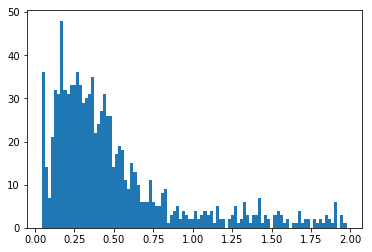

In [62]:
%pylab inline
plt.hist(lst,bins=100);
print np.mean(lst) 

1369.5 1535.96 0.112899


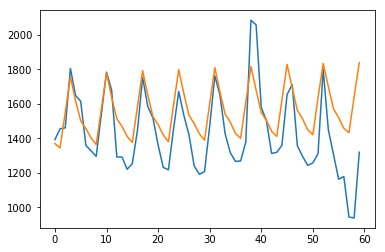

In [75]:
i=856
u=Y[i][:60]
v=a[i]
plt.plot(u)
plt.plot(v)
print np.median(u),np.median(v), (2*np.abs(u-v)/(np.abs(u)+np.abs(v))).mean()

In [76]:
daily_data.shape,attrib_data.shape

((145063, 550), (145063, 12))

In [79]:
daily_test=daily_data[:,-128:]
attrib_test=attrib_data
daily_test.shape,attrib_test.shape

((145063, 128), (145063, 12))

In [80]:
feed_dict={x:daily_test,x2:attrib_test}
predTest=sess.run(prediction,feed_dict=feed_dict)
predTest.shape

(145063, 60)

In [81]:
predTest=np.round(predTest,1)
np.mean(predTest<1)

0.031476094294662776

In [82]:
cols=pd.date_range(pd.datetime.date(datetime.datetime(2017, 1, 1)), periods=60).map(lambda u: u.strftime("%Y-%m-%d"))
idx=pd.read_csv("../input/train_1.csv",usecols=[0])["Page"]
idx.shape

(145063,)

In [83]:
submission=pd.DataFrame(predTest,columns=cols,index=idx)
submission=submission.unstack().reset_index()
submission['name']=submission.apply(lambda r: r['Page']+"_"+r['level_0'],axis=1)
submission=submission.drop(['Page','level_0'],axis=1)
submission.columns=['Visits','name']

In [84]:
submission=submission[["name",'Visits']]
submission.head()

name     Visits
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  18.299999
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  19.200001
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   4.700000
3  4minute_zh.wikipedia.org_all-access_spider_201...  13.400000
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  10.600000

In [85]:
keys=pd.read_csv("../input/key_1.csv",index_col=0)

In [86]:
keys_dict=keys["Id"].to_dict()

In [87]:
submission["Id"]=submission["name"].apply(lambda u:keys_dict[u])

In [88]:
submission.isnull().sum().sum()

0L

In [89]:
submission.head()

name     Visits            Id
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  18.299999  ff8c1aade3de
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  19.200001  3da6fd5b23c1
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   4.700000  cd9e83803be4
3  4minute_zh.wikipedia.org_all-access_spider_201...  13.400000  65cd4af0968c
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  10.600000  75bae1fb2637

In [90]:
submission[["Id","Visits"]].to_csv("../submission/sub_pred_lstm1_60.csv.gz",
                                   index=None, float_format='%.1f', compression="gzip")